<a href="https://colab.research.google.com/github/aishwaryaranga/Short-term-Traffic-Flow-Prediction/blob/main/Short_Term_Traffic_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting with Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
import seaborn as sns
from matplotlib import rc
from pylab import rcParams

rcParams['figure.figsize'] = 22, 6
print('Libraries Imported Successfully')

Libraries Imported Successfully


Load the data

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/STFP/london_merged.csv',parse_dates=['timestamp'],index_col='timestamp')
df.head()
print('Data has been loaded')

Data has been loaded


Get a copy of the data

In [4]:
df_copy = df.copy()
print('Copy created')

Copy created


*Exploratory Data Analysis*

Extracting extra features from timestamps

In [5]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month
print('Features extracted')
df.head()

Features extracted


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


Total numbers of bike shared during the period

Graph one


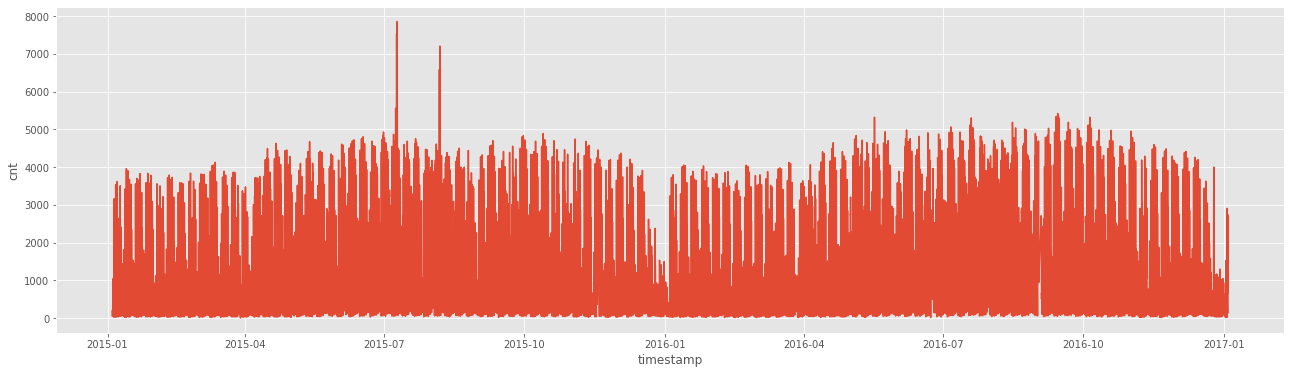

In [6]:
sns.lineplot(x=df.index, y=df.cnt);
print('Graph one')

total numbers of bike shared during each month

graph 2


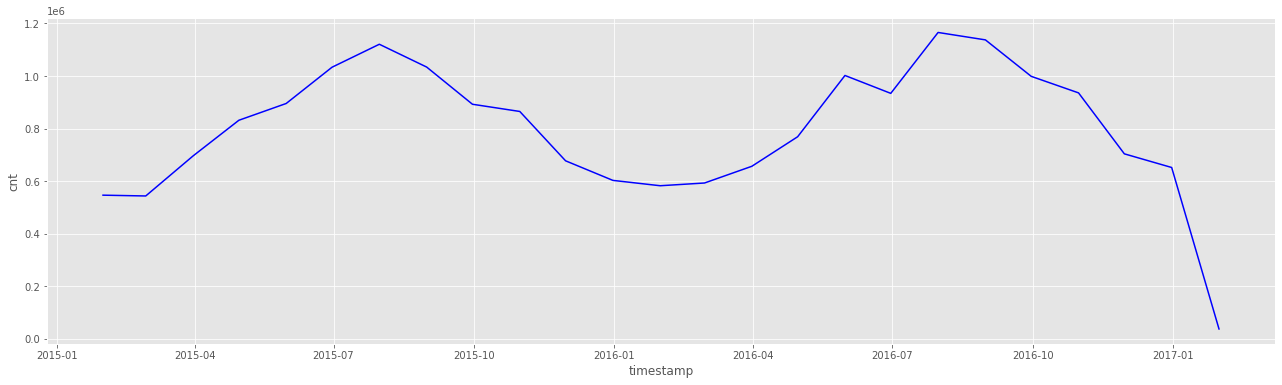

In [7]:
df_by_month = df.resample('M').sum()
sns.lineplot(x=df_by_month.index, y='cnt', data=df_by_month, color='b');
print('graph 2')

total numbers of bike shared in each hour in comparison with holidays

graph 3


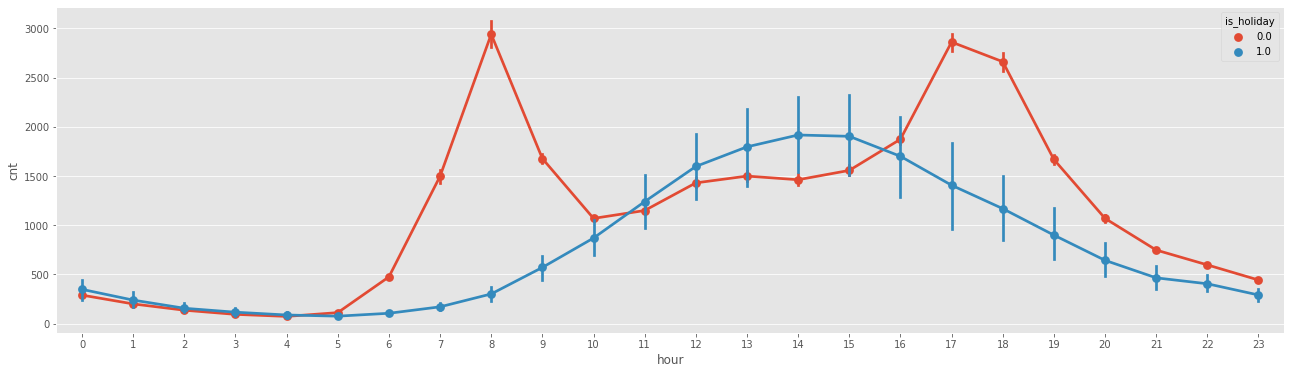

In [8]:
sns.pointplot(x='hour',y='cnt', data=df, hue='is_holiday');
print('graph 3')

total numbers of bike shared during each day of the week

graph 4


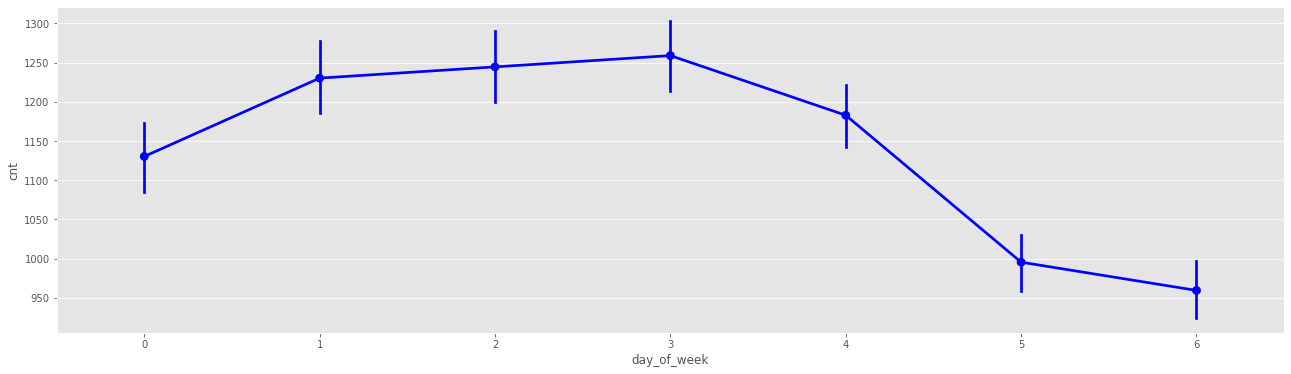

In [9]:
sns.pointplot(x='day_of_week',y='cnt', data=df, color='b');
print('graph 4')

Splitting Train and Test

In [10]:
train_size = int(len(df_copy)*0.9)
test_size = len(df) - train_size
train , test = df.iloc[:train_size], df.iloc[train_size:]
print(train.shape, test.shape)
print('split done')

(15672, 13) (1742, 13)
split done


Feature Scaling

In [11]:
from sklearn.preprocessing import RobustScaler
pd.options.mode.chained_assignment = None

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])
print('features scaled')

features scaled


Converting the data to a time series format

In [12]:
def to_sequence(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i + time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.asarray(Xs), np.asarray(ys)

TIMESTEPS = 24

x_train, y_train = to_sequence(train, train['cnt'], TIMESTEPS)
x_test, y_test = to_sequence(test, test['cnt'], TIMESTEPS)
print(f"X_train shape is {x_train.shape}, and y_train shape is {y_train.shape}")
print('data converted')

X_train shape is (15648, 24, 13), and y_train shape is (15648,)
data converted


Defining a model

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Bidirectional, Dense
model = Sequential()
model.add(Bidirectional(LSTM(units=128),input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
print('model defined')
model.summary()

model defined
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               145408    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 145,665
Trainable params: 145,665
Non-trainable params: 0
_________________________________________________________________


Fitting the model on data

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, validation_split=0.1, epochs=100, shuffle=False)
print('model fitted')

Epoch 1/100
881/881 [==============================] - 34s 35ms/step - loss: 0.2029 - acc: 6.3907e-04 - val_loss: 0.0999 - val_acc: 6.3898e-04
Epoch 2/100
881/881 [==============================] - 30s 34ms/step - loss: 0.0684 - acc: 9.2310e-04 - val_loss: 0.0565 - val_acc: 6.3898e-04
Epoch 3/100
881/881 [==============================] - 30s 34ms/step - loss: 0.0437 - acc: 9.2310e-04 - val_loss: 0.0412 - val_acc: 6.3898e-04
Epoch 4/100
881/881 [==============================] - 30s 34ms/step - loss: 0.0351 - acc: 9.2310e-04 - val_loss: 0.0378 - val_acc: 6.3898e-04
Epoch 5/100
621/881 [====================>.........] - ETA: 8s - loss: 0.0303 - acc: 0.0010

Model loss visualization

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();
print('loss visualised')

# Model Prediction

In [ ]:
y_pred = model.predict(x_test)

y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
print('prediction')

# Model prediction visualization

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label='True')
plt.plot(y_pred_inv, marker='.', label='Prediction')
plt.legend();
print('visualisation of prediction')